In [16]:
from lavis.models import model_zoo

import re
import torch
from torch import nn
from torchvision import transforms

import json
import pickle
from PIL import Image

import cv2
import numpy as np

from skimage import transform as skimage_transform
from scipy.ndimage import filters
from matplotlib import pyplot as plt

import requests
from lavis.models import load_model_and_preprocess, load_model

from tqdm import tqdm

from CustomDataset import CustomDataset
from torch.utils.data import DataLoader


# model optim
from torch.optim import AdamW, SGD

# lr schedulers
from transformers import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model, vision_processer, lang_processer = load_model_and_preprocess(name="blip2", model_type="pretrain")

In [4]:
model.to(device)

Blip2Qformer(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-38): 39 x Block(
        (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1408, out_features=4224, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1408, out_features=1408, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1408, out_features=6144, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )


In [5]:
dataset = CustomDataset("/home/ubuntu/Text_Guided_Image_Editing/data")

dataset built with 18 instances


In [6]:
print(dataset[0])

(<PIL.Image.Image image mode=RGB size=781x781 at 0x7FDBAB552110>, 'dog', 'a brown-and-white dog ')


In [7]:
train_dataloader = DataLoader(dataset, shuffle=True, batch_size=1)

In [8]:
epoch=25
lr=1e-5
eps=5e-5

In [9]:
model.optimizer = AdamW(model.parameters(), lr=lr, eps=eps)

train_steps = epoch*len(train_dataloader)
warm_step = int(train_steps*0.1)
model.scheduler = get_cosine_schedule_with_warmup(model.optimizer, num_warmup_steps=warm_step,num_training_steps=train_steps)

In [10]:
all_loss = []

for e in tqdm(range(epoch)):
    
    losses = 0
    for image, label, text in dataset:
        
        image = vision_processer["eval"](image).unsqueeze(0)
        
        samples = {'image': image.to(device), 'text_input': text}
        
        output = model(samples)
        loss = output['loss']
        
        losses += loss.item()
        
        model.zero_grad()
        loss.backward()
        
        model.optimizer.step()  # backprop to update the weights

        if model.scheduler is not None:
            model.scheduler.step()  # update learning rate schedule 
    
    print("epoch: ", e, "losses: ", losses/len(dataset))
    all_loss.append(losses/len(dataset))
        

  4%|███▎                                                                                | 1/25 [00:03<01:20,  3.36s/it]

epoch:  0 losses:  3.9340222809049816


  8%|██████▋                                                                             | 2/25 [00:06<01:10,  3.07s/it]

epoch:  1 losses:  3.0008996725082397


 12%|██████████                                                                          | 3/25 [00:09<01:05,  2.97s/it]

epoch:  2 losses:  2.2828535503811307


 16%|█████████████▍                                                                      | 4/25 [00:11<01:01,  2.93s/it]

epoch:  3 losses:  1.9343427817026775


 20%|████████████████▊                                                                   | 5/25 [00:14<00:58,  2.91s/it]

epoch:  4 losses:  1.7598751187324524


 24%|████████████████████▏                                                               | 6/25 [00:17<00:54,  2.89s/it]

epoch:  5 losses:  1.6400620539983113


 28%|███████████████████████▌                                                            | 7/25 [00:20<00:51,  2.88s/it]

epoch:  6 losses:  1.5667252739270527


 32%|██████████████████████████▉                                                         | 8/25 [00:23<00:48,  2.88s/it]

epoch:  7 losses:  1.5155171420839098


 36%|██████████████████████████████▏                                                     | 9/25 [00:26<00:45,  2.87s/it]

epoch:  8 losses:  1.4751635591189067


 40%|█████████████████████████████████▏                                                 | 10/25 [00:29<00:43,  2.87s/it]

epoch:  9 losses:  1.4486213193999395


 44%|████████████████████████████████████▌                                              | 11/25 [00:32<00:40,  2.87s/it]

epoch:  10 losses:  1.4354583091206021


 48%|███████████████████████████████████████▊                                           | 12/25 [00:34<00:37,  2.87s/it]

epoch:  11 losses:  1.4266893598768446


 52%|███████████████████████████████████████████▏                                       | 13/25 [00:37<00:34,  2.87s/it]

epoch:  12 losses:  1.4205532471338909


 56%|██████████████████████████████████████████████▍                                    | 14/25 [00:40<00:31,  2.87s/it]

epoch:  13 losses:  1.4161028861999512


 60%|█████████████████████████████████████████████████▊                                 | 15/25 [00:43<00:28,  2.87s/it]

epoch:  14 losses:  1.412817656993866


 64%|█████████████████████████████████████████████████████                              | 16/25 [00:46<00:25,  2.87s/it]

epoch:  15 losses:  1.4103510313563876


 68%|████████████████████████████████████████████████████████▍                          | 17/25 [00:49<00:22,  2.87s/it]

epoch:  16 losses:  1.408484399318695


 72%|███████████████████████████████████████████████████████████▊                       | 18/25 [00:52<00:20,  2.86s/it]

epoch:  17 losses:  1.4070728023846943


 76%|███████████████████████████████████████████████████████████████                    | 19/25 [00:54<00:17,  2.87s/it]

epoch:  18 losses:  1.4060156875186496


 80%|██████████████████████████████████████████████████████████████████▍                | 20/25 [00:57<00:14,  2.86s/it]

epoch:  19 losses:  1.405240125126309


 84%|█████████████████████████████████████████████████████████████████████▋             | 21/25 [01:00<00:11,  2.87s/it]

epoch:  20 losses:  1.4046913584073384


 88%|█████████████████████████████████████████████████████████████████████████          | 22/25 [01:03<00:08,  2.88s/it]

epoch:  21 losses:  1.404325889216529


 92%|████████████████████████████████████████████████████████████████████████████▎      | 23/25 [01:06<00:05,  2.91s/it]

epoch:  22 losses:  1.4041056765450373


 96%|███████████████████████████████████████████████████████████████████████████████▋   | 24/25 [01:09<00:02,  2.91s/it]

epoch:  23 losses:  1.403995500670539


100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [01:12<00:00,  2.89s/it]

epoch:  24 losses:  1.4039608505037096


In [14]:
with open("tune_losses", 'wb') as f:
    pickle.dump(all_loss, f)

Text(0, 0.5, 'Loss')

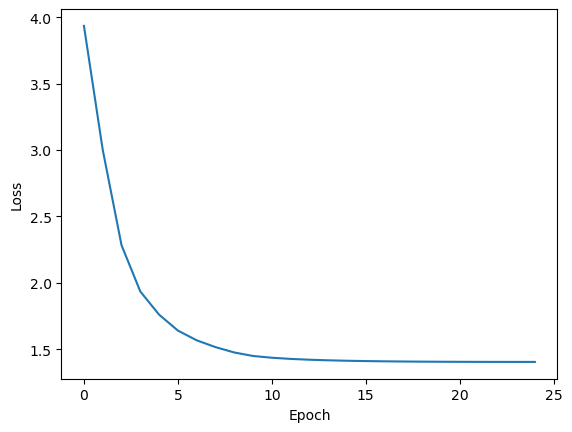

In [19]:
plt.plot(all_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
torch.save(model, 'model.pth')

In [ ]:
# model = torch.load('model.pth')